# Leg reversion study
---

In [159]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os



## Data
---

In [160]:

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
#prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)

In [161]:
#prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
#prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

prices = prices[['XRPUSDT_2024_5m', 'ADAUSDT_2024_5m']]

#Filter for INJUSDT_2024_5m ~ LDOUSDT_2024_5m

#prices = prices[['INJUSDT_2024_5m', 'LDOUSDT_2024_5m']]

#prices = prices[['DOGEUSDT_2024_5m', 'LTCUSDT_2024_5m']]



In [162]:
#Filter prices from January 2024 to March 2024
#-------------------------------------------

#prices = prices.loc['2024-01-01':'2024-06-30']


## Params
---

In [163]:
#Params:
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

## Investigation
---

In [164]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)



Testing strategy on pair: XRPUSDT_2024_5m and ADAUSDT_2024_5m ...
Total trades closed: 124 (Wins=124, Losses=0)
Win rate: 1.00


In [165]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.000 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Total trades: 124
Number of profitable trades (proft > 0): 90
Number of non-profitable trades (proft < 0): 34
Total return €: 2114.48
Total return %: 21.14%
Long spread losses: 20, Short spread losses: 14
Number of Dual-leg profitable trades: 28
Dual leg trade profit rate: 22.58%


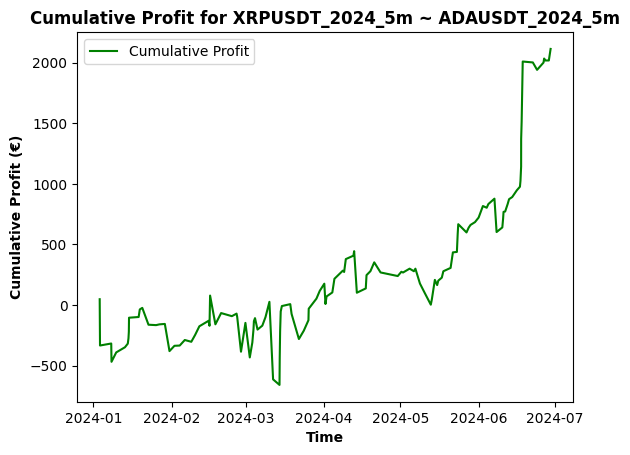

In [166]:
plt.plot(cumulative_profit_series, label='Cumulative Profit', color = 'green')
plt.title(f"Cumulative Profit for {sym1} ~ {sym2}", fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Cumulative Profit (€)' , fontweight='bold')
plt.legend()

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/cumulative_profit.png", dpi=300)

In [167]:
#Compute non-stop loss win rate

trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]
non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100



if(stop_loss_threshold > 50):

    print(f"Average trade wins: {np.mean(trade_wins):.2f}")
    print(f"Average trade losses: {np.mean(trade_losses):.2f}")
    print(f"Number of wins: {len(trade_wins)}")
    print(f"Number of losses: {len(trade_losses)}")
    print(f"Non-stop loss win rate: {non_stop_loss_win_rate:.2f}%")



Average trade wins: 71.62
Average trade losses: -127.40
Number of wins: 90
Number of losses: 34
Non-stop loss win rate: 72.58%


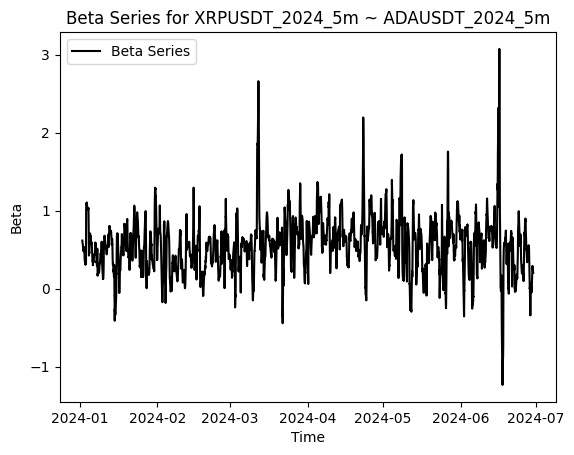

In [168]:
plt.plot(beta_series, label='Beta Series', color = 'black')
plt.title(f"Beta Series for {sym1} ~ {sym2}")
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

In [169]:
trade_durations = [(exit - entry).total_seconds() / 60 for entry, exit in zip(entry_times, exit_times)]

In [170]:
#Percentage changes in S1 and S2 each trade
trade_percentage_changes = []
for entry_time, exit_time in zip(entry_times, exit_times):
    # Calculate percentage change for S1 and S2
    price_change_S1 = (S1[exit_time] - S1[entry_time]) / S1[entry_time] * 100
    price_change_S2 = (S2[exit_time] - S2[entry_time]) / S2[entry_time] * 100
    trade_percentage_changes.append((price_change_S1, price_change_S2))

#Average absolute percentage change in S1 and S2
average_absolute_percentage_changes = [abs(s1+s2)/2 for s1, s2 in trade_percentage_changes]

#Compute abs trade profits 
abs_trade_profits = [abs(profit) for profit in trade_profits]
#Compute average trade profits

Correlation between average absolute percentage changes and absolute trade profits: 0.6326


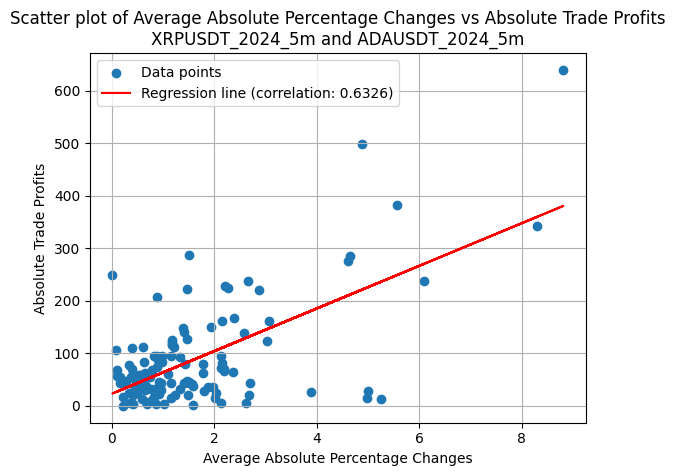

In [171]:
#Scatter plot for average_absolute_percentage_changes vs abs_trade_profits with regression line

# Fit a linear regression model


#Compute correlation between average_absolute_percentage_changes and abs_trade_profits
correlation = np.corrcoef(average_absolute_percentage_changes, abs_trade_profits)[0, 1]
print(f"Correlation between average absolute percentage changes and absolute trade profits: {correlation:.4f}")

X = np.array(average_absolute_percentage_changes).reshape(-1, 1)
y = np.array(abs_trade_profits)
model = LinearRegression()
model.fit(X, y)
# Predict y values
y_pred = model.predict(X)
# Plot the scatter plot with regression line
plt.scatter(average_absolute_percentage_changes, abs_trade_profits, label='Data points')
plt.plot(average_absolute_percentage_changes, y_pred, color='red', label='Regression line (correlation: {:.4f})'.format(correlation))
plt.xlabel('Average Absolute Percentage Changes')
plt.ylabel('Absolute Trade Profits')
plt.title(f'Scatter plot of Average Absolute Percentage Changes vs Absolute Trade Profits\n{sym1} and {sym2}')
#Add correlation to the legend

plt.legend()
plt.grid()

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Average_Absolute_Percent_Changes_Vs_Absolute_Trade_Profits.png", dpi=300)







In [172]:
#Check Effect Of net Exposure 
beta_series_trades = beta_series[entry_times]

avg_beta = np.mean(beta_series_trades)

if(avg_beta < 1):
    net_exposure = "S1"
else:
    net_exposure = "S2"

print("avg_beta: ", avg_beta)
print(f"Net exposure: {net_exposure}")



avg_beta:  0.47579482528313016
Net exposure: S1


In [173]:
#An example of a trade where you were net long S1 but still made profit due to S2's hedge, where S2 moved more than S1

# Trade type: -1, Entry time: 2024-03-18 03:12:00, Exit time: 2024-03-18 05:41:00
# Net Trade profit (includes fees): 58.2461918883329
# Beta at entry (Not the absolute value): 0.6246522836635335
# Notional S1: 6155.163231267156, Notional S2: 3844.836768732843, Shares S1 : 9871.953859289744, Shares S2: 5721.483286804826
# Percentage change S1: 0.38%, Percentage change S2: 2.26%
# Trade Num: 65

In [174]:
#Check if losses were caused due to losses in leg that you are nex exposed to

positions_trades = list(positions[entry_times])
S1_trade_returns = [percentage_changes[0] for percentage_changes in trade_percentage_changes]
S2_trade_returns = [percentage_changes[1] for percentage_changes in trade_percentage_changes]

net_exposed_return = []

if net_exposure == "S1":
    net_exposed_return = S1_trade_returns
elif net_exposure == "S2":
    net_exposed_return = S2_trade_returns

losses_due_to_exposure = 0

for position, net_exposed_return, trade_profit in zip(positions_trades,net_exposed_return,trade_profits):

    if(position == 1 and net_exposed_return < 0 and trade_profit < 0 or position == -1 and net_exposed_return > 0 and trade_profit < 0):
        losses_due_to_exposure +=1
    
    elif trade_profit < 0 :
        print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")

    # elif (position == 1 and net_exposed_return < 0 and trade_profit > 0 or position == -1 and net_exposed_return > 0 and trade_profit > 0):

    #     print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")



print(f"Number of trades where losses were due to exposure: {losses_due_to_exposure}")
print(f"Percentage of losses caused due to exposure: {losses_due_to_exposure / len(trade_losses) * 100:.2f}%")

Position 1, Net Exposed Return: 1.0343481654957225, Trade Profit: -14.7324728638023
Position 1, Net Exposed Return: 0.14500634402755538, Trade Profit: -40.96359153739215
Position 1, Net Exposed Return: 0.3459577567370744, Trade Profit: -237.4174118913491
Position 1, Net Exposed Return: 2.753158589477665, Trade Profit: -26.906808250156075
Position 1, Net Exposed Return: 0.720376359894151, Trade Profit: -45.90555437572198
Position -1, Net Exposed Return: -0.5823358136525294, Trade Profit: -80.95141618104108
Position 1, Net Exposed Return: 0.2654531664770701, Trade Profit: -122.61688127970106
Position 1, Net Exposed Return: 2.1447183804369696, Trade Profit: -42.9731999581939
Position 1, Net Exposed Return: 0.3848374061958826, Trade Profit: -14.075588326494511
Position -1, Net Exposed Return: -0.4498977505112433, Trade Profit: -7.566007159500533
Position -1, Net Exposed Return: -0.9135330359039783, Trade Profit: -16.104161494484707
Number of trades where losses were due to exposure: 23
Per

In [175]:

#Compute beta series returns
beta_series_returns = beta_series.pct_change().dropna()

#Compute variance of beta series returns
std_beta_series = beta_series_returns.std() * 100
print(f"Std of beta series returns: {std_beta_series:.4f}")


#Volatility of the spread
z_score_spread_std = zscore_series.std()
print(f"Spread Standard Deviation: {z_score_spread_std:.4f}")

Std of beta series returns: 123.4522
Spread Standard Deviation: 1.2812


In [176]:

#Get actual Betas used for each trade entry
beta_entries = [beta_series[entry] for entry in entry_times]

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges

beta_series_trade_ranges = [beta_series[entry:exit].iloc[1:] for entry, exit in trade_ranges] #iloc[1:] to exclude the first beta value which is the same as the entry beta

#Calculate the percent absolute difference between the beta at the trade entry and the betas in the trade range
absolute_percent_delta_betas = [np.abs(((entry_beta - beta_range)/entry_beta)*100) for entry_beta, beta_range in zip(beta_entries, beta_series_trade_ranges)]

#Calculate the mean delta beta for each trade
mean_absolute_percent_delta_betas = [np.mean(delta) for delta in absolute_percent_delta_betas]


In [177]:
np.mean(mean_absolute_percent_delta_betas)

np.float64(78.3114252890298)

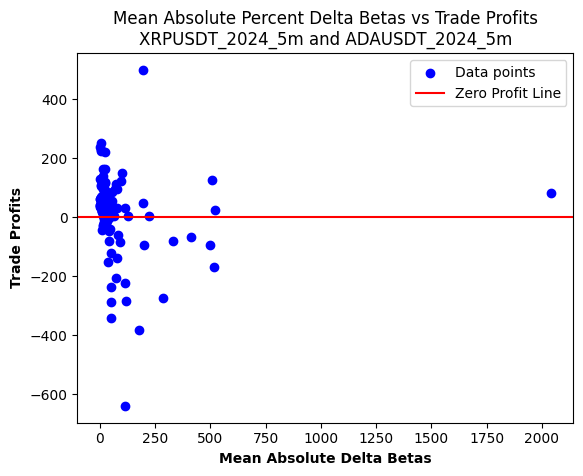

In [178]:
plt.scatter(mean_absolute_percent_delta_betas, trade_profits, color = 'blue', label='Data points')
plt.xlabel('Mean Absolute Delta Betas', fontweight = 'bold')
plt.ylabel('Trade Profits', fontweight='bold')
plt.title(f'Mean Absolute Percent Delta Betas vs Trade Profits\n{sym1} and {sym2}')
plt.axhline(0, color = 'red', label='Zero Profit Line')
plt.legend()

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Mean_Absolute_Percent_Delta_Betas_Vs_Trade_Profits.png", dpi=300)


In [179]:
#del range

In [180]:
print(max(mean_absolute_percent_delta_betas))

2039.6688878527916


# Buckets for mean absolute percent delta betas
---

In [181]:
#Create ranges from mean_absolute_delta_betas using the max value

# #Create ranges from 0 to max_mean_absolute_percent_delta_beta with a step of 5%

max_mean_absolute_percent_delta_beta = max(mean_absolute_percent_delta_betas)

ranges = np.arange(0, max_mean_absolute_percent_delta_beta, 10)

#zip elements of the array with the next element
ranges = list(zip(ranges[:-1], ranges[1:]))



# #Create tuples of ranges
# ranges = [(i, (i+5)) for i in ranges]


# ranges = []

# #
# for i in range(0, max_mean_absolute_percent_delta_beta, 5):
#     ranges.append((i, (i+5)/100))

#Count the number of trades where the mean absolute delta beta is in the range
mean_absolute_percent_delta_betas_ranges_counts = []
for i in range(len(ranges)):
    mean_absolute_percent_delta_betas_ranges_counts.append(0)

#Count the number of trades where the mean absolute delta beta is in the range
for mean_absolute_percent_delta_beta in mean_absolute_percent_delta_betas:
    for i in range(len(ranges)):
        if mean_absolute_percent_delta_beta >= ranges[i][0] and mean_absolute_percent_delta_beta < ranges[i][1]:
            mean_absolute_percent_delta_betas_ranges_counts[i] += 1
            break

In [194]:
buckets = [i for i in range(len(ranges))]


#Create a dataframe with the bucket number corresponding to each range
ranges_df = pd.DataFrame({'Bucket': [i for i in buckets], 'Mean_Absolute_Percent_Delta_Beta_Range (%)': [(ranges[i][0],ranges[i][1]) for i in range(len(ranges))], "Number of Trades": mean_absolute_percent_delta_betas_ranges_counts})
ranges_df


,Bucket,Mean_Absolute_Percent_Delta_Beta_Range (%),Number of Trades
0,0,"(0.0, 10.0)",25
1,1,"(10.0, 20.0)",24
2,2,"(20.0, 30.0)",17
3,3,"(30.0, 40.0)",14
4,4,"(40.0, 50.0)",9
...,...,...,...
198,198,"(1980.0, 1990.0)",0
199,199,"(1990.0, 2000.0)",0
200,200,"(2000.0, 2010.0)",0
201,201,"(2010.0, 2020.0)",0


In [183]:
trades_data = list(zip(trade_profits,mean_absolute_percent_delta_betas))

trade_win_rates = []
probability_of_losses = []
trade_wins_list = [] #Keep track of the number of trade wins for each range/bucket
trade_losses_list = [] #Keep track of the number of trade losses for each range/bucket

for delta_range in ranges:
    trade_wins = 0
    trade_losses = 0
    probability_of_loss = 0
    for trade_data in trades_data:
        if trade_data[1] >= delta_range[0] and trade_data[1] <= delta_range[1]: #If the mean_absolute_percent_delta_beta for this trade was in the range
            if trade_data[0] > 0: #If the trade profit was positive
                trade_wins += 1
            else:
                trade_losses += 1 #If the trade profit was negative
    if trade_wins + trade_losses > 0: #If there were any trades in this range
        trade_wins_percentage = trade_wins / (trade_wins + trade_losses) * 100
        probability_of_loss = trade_losses / (trade_wins + trade_losses) * 100
        trade_range = (delta_range[0], delta_range[1])
        print(f"Range: {delta_range[0]} - {delta_range[1]}, Trade wins: {trade_wins}, Trade losses: {trade_losses}, Probability of loss: {probability_of_loss:.2f}%")
    else:   
        probability_of_loss = "N/A"
        

    trade_win_rates.append(trade_wins_percentage)
    probability_of_losses.append(probability_of_loss)
    trade_wins_list.append(trade_wins)
    trade_losses_list.append(trade_losses)
    

ranges_df['Number of Trade Wins'] = trade_wins_list
ranges_df['Number of Trade Losses'] = trade_losses_list
ranges_df['Probability of Loss (%)'] = probability_of_losses

    

Range: 0.0 - 10.0, Trade wins: 25, Trade losses: 0, Probability of loss: 0.00%
Range: 10.0 - 20.0, Trade wins: 18, Trade losses: 6, Probability of loss: 25.00%
Range: 20.0 - 30.0, Trade wins: 14, Trade losses: 3, Probability of loss: 17.65%
Range: 30.0 - 40.0, Trade wins: 10, Trade losses: 4, Probability of loss: 28.57%
Range: 40.0 - 50.0, Trade wins: 5, Trade losses: 4, Probability of loss: 44.44%
Range: 50.0 - 60.0, Trade wins: 3, Trade losses: 3, Probability of loss: 50.00%
Range: 60.0 - 70.0, Trade wins: 2, Trade losses: 0, Probability of loss: 0.00%
Range: 70.0 - 80.0, Trade wins: 2, Trade losses: 2, Probability of loss: 50.00%
Range: 80.0 - 90.0, Trade wins: 1, Trade losses: 1, Probability of loss: 50.00%
Range: 90.0 - 100.0, Trade wins: 2, Trade losses: 1, Probability of loss: 33.33%
Range: 110.0 - 120.0, Trade wins: 1, Trade losses: 3, Probability of loss: 75.00%
Range: 120.0 - 130.0, Trade wins: 1, Trade losses: 0, Probability of loss: 0.00%
Range: 170.0 - 180.0, Trade wins: 0

In [184]:
ranges_df.head(50)

,Bucket,Mean_Absolute_Percent_Delta_Beta_Range (%),Number of Trades,Number of Trade Wins,Number of Trade Losses,Probability of Loss (%)
0,0,"(0.0, 10.0)",25,25,0,0.0
1,1,"(10.0, 20.0)",24,18,6,25.0
2,2,"(20.0, 30.0)",17,14,3,17.647059
3,3,"(30.0, 40.0)",14,10,4,28.571429
4,4,"(40.0, 50.0)",9,5,4,44.444444
5,5,"(50.0, 60.0)",6,3,3,50.0
6,6,"(60.0, 70.0)",2,2,0,0.0
7,7,"(70.0, 80.0)",4,2,2,50.0
8,8,"(80.0, 90.0)",2,1,1,50.0
9,9,"(90.0, 100.0)",3,2,1,33.333333


Text(0.5, 1.0, 'Mean Absolute Delta Betas Ranges\nXRPUSDT_2024_5m and ADAUSDT_2024_5m')

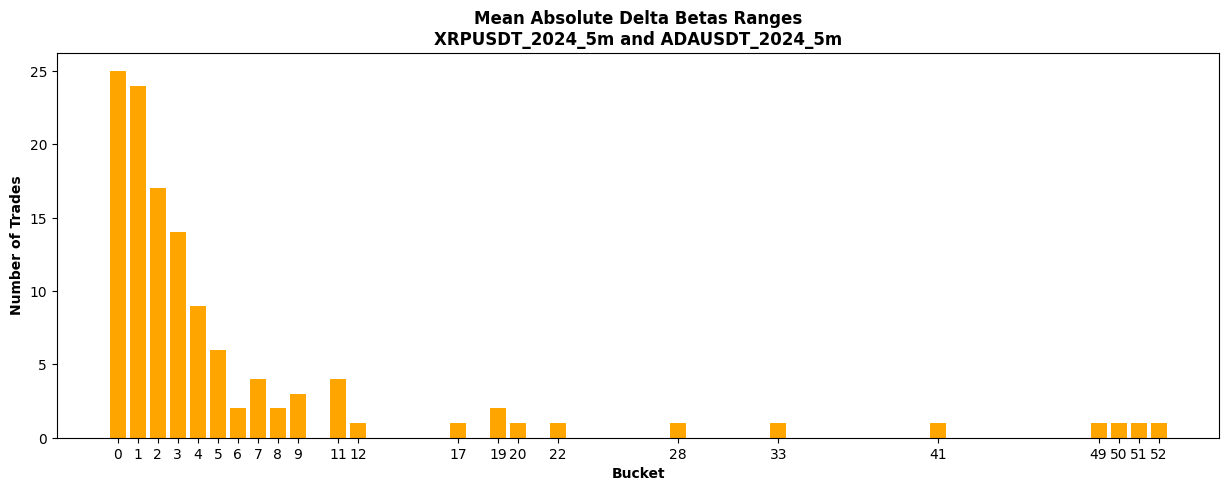

In [185]:
#Filter out the ranges with 0 trades
ranges_df = ranges_df[ranges_df['Number of Trades'] > 0] 

buckets = ranges_df['Bucket']
number_of_trades = ranges_df['Number of Trades']

#Create a bar plot of the number of trades in each bucket
plt.figure(figsize=(15, 5))
plt.bar(buckets, number_of_trades, color = 'orange')
plt.xticks(buckets)
plt.xlabel('Bucket', fontweight = 'bold')
plt.ylabel('Number of Trades', fontweight = 'bold')
plt.title(f'Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}', fontweight = 'bold')


# #Filter mean_absolute_percent_delta_betas_ranges_counts to only include the ranges that have counts
# mean_absolute_percent_delta_betas_ranges_counts = [count for count in mean_absolute_percent_delta_betas_ranges_counts if count > 0]
# #Filter ranges to only include the ranges that have counts
# ranges = [range_ for count, range_ in zip(mean_absolute_percent_delta_betas_ranges_counts, ranges) if count > 0]


# plt.figure(figsize=(35, 5))
# #Plot the ranges
# plt.bar(range(len(ranges)), mean_absolute_percent_delta_betas_ranges_counts)
# plt.xticks(range(len(ranges)))
# #plt.xticks(range(len(ranges)), [f"{ranges[i][0]} - {ranges[i][1]}" for i in range(len(ranges))])
# plt.xlabel('Bucket')
# plt.ylabel('Number of Trades')
# plt.title(f'Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}')
# plt.axhline(0, color = 'red')
# plt.axvline(0.05)

# #Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
# if not os.path.exists(f"results/{sym1}_{sym2}"):
#     os.makedirs(f"results/{sym1}_{sym2}")
# #Save the plot
# plt.savefig(f"results/{sym1}_{sym2}/Mean_Absolute__Percent_Delta_Beta_Ranges.png", dpi=300)

# Probability of loss given delta neutrality 
---


/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_50338/2845066984.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


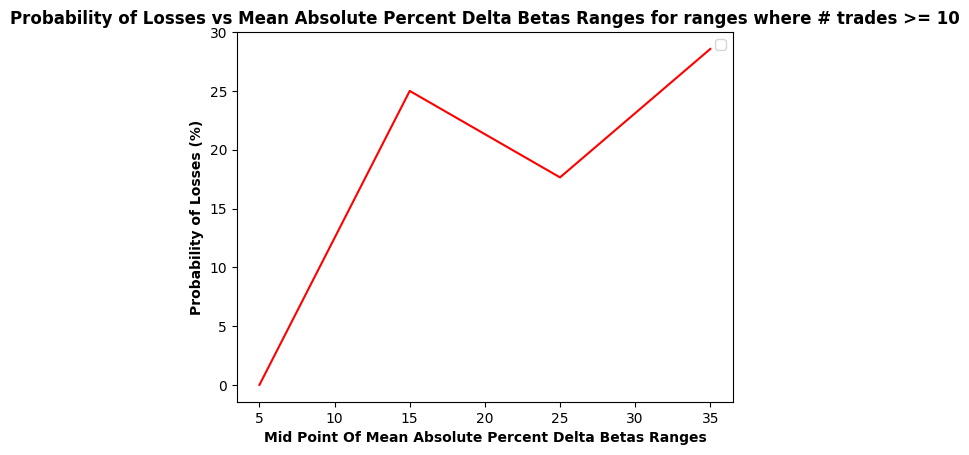

In [186]:
#Filter out rows where the number of trades is less than 3
ranges_df_filtered = ranges_df[ranges_df['Number of Trades'] >= 10]


ranges_mid_points = [(full_range[0]+full_range[1])/2 for full_range in ranges_df_filtered['Mean_Absolute_Percent_Delta_Beta_Range (%)']]

# #Plot trade ranges and probability of losses on a line chart

#plt.figure(figsize=(35, 5))
plt.plot(ranges_mid_points, ranges_df_filtered['Probability of Loss (%)'], color='red')
plt.xlabel('Mid Point Of Mean Absolute Percent Delta Betas Ranges', fontweight='bold')
plt.ylabel('Probability of Losses (%)', fontweight='bold')
plt.title(f'Probability of Losses vs Mean Absolute Percent Delta Betas Ranges for ranges where # trades >= 10', fontweight='bold')
plt.legend()

# #Plot trade ranges and probability of losses on bar chart
# range_midpoints = [(full_range[0]+full_range[1])/2 for full_range in ranges]

# plt.plot(range_midpoints, probability_of_losses, label='Probability of Losses')
# plt.xlabel('Mean Absolute Delta Betas Ranges')
# plt.ylabel('Probability of Losses (%)')
# plt.title(f'Probability of Losses vs Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}')
# #Plot the ranges

# #Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
# if not os.path.exists(f"results/{sym1}_{sym2}"):
#     os.makedirs(f"results/{sym1}_{sym2}")
# #Save the plot
# plt.savefig(f"results/{sym1}_{sym2}/Probability_of_Losses_Vs_Mean_Absolute_Delta_Betas_Ranges.png", dpi=300)



In [187]:
np.mean(mean_absolute_percent_delta_betas)

np.float64(78.3114252890298)

# Trade duration vs mean absolute percent delta beta
---

Text(0.5, 1.0, 'Trade Durations vs Mean Absolute Percent Delta Betas\nXRPUSDT_2024_5m and ADAUSDT_2024_5m')

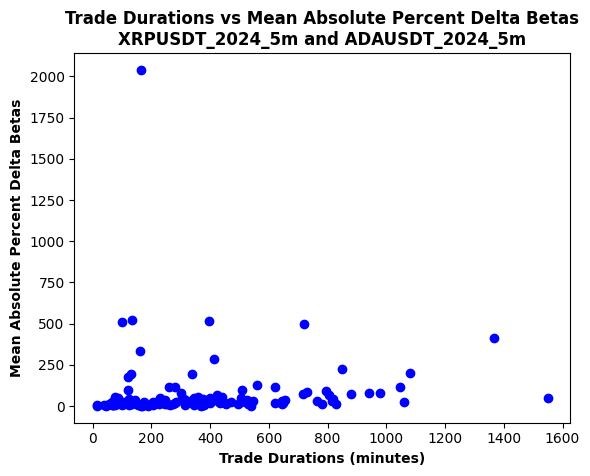

In [188]:
#Create scatter plot of trade durations vs mean absolute percent delta betas



plt.scatter(trade_durations, mean_absolute_percent_delta_betas, color='blue')
plt.xlabel('Trade Durations (minutes)', fontweight='bold')  
plt.ylabel('Mean Absolute Percent Delta Betas', fontweight='bold')
plt.title(f'Trade Durations vs Mean Absolute Percent Delta Betas\n{sym1} and {sym2}', fontweight='bold')



### There is no clear relationship here. My hypothesis is that it really comes down to home much Beta fluctuates. Beta could fluctate a very small amount for long trade intervals and a lot for shorter trade intervals and vice-versa, hence no clear relationship.

# Summart of metrics
----

In [189]:
#Create dataframe to store key metrics:


trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]
non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100


mean_trade_duration = np.mean(trade_durations)
average_absolute__percent_delta_beta = np.mean(mean_absolute_percent_delta_betas)
average_S1_trade_returns = np.mean(S1_trade_returns)
average_S2_trade_returns = np.mean(S2_trade_returns)


key_metrics = pd.DataFrame({
    'Pair': f"{sym1} ~ {sym2}",
    'Total return (%)': cumulative_profit_series[-1]/initial_capital * 100,
    'Number of trades': len(trade_profits),
    'Non-stop loss win rate (%)': non_stop_loss_win_rate,
    f'Mean trade duration/Reversion speed from threshold (mins)': mean_trade_duration,
    'Average entry beta': avg_beta,
    'Mean Absolute Percent Delta Beta (%)': average_absolute__percent_delta_beta,
    'Beta series returns std (%)': std_beta_series,
    #'Spread series z-score std (%)': z_score_spread_std,
    'Average S1 trade returns (%)': average_S1_trade_returns,
    'Average S2 trade returns (%)': average_S2_trade_returns,
},index=[0])

#Save key metrics to csv
key_metrics.to_csv(f'results/{sym1}_{sym2}/key_metrics.csv', index=False)

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_50338/4187992567.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Total return (%)': cumulative_profit_series[-1]/initial_capital * 100,


In [190]:
key_metrics

,Pair,Total return (%),Number of trades,Non-stop loss win rate (%),Mean trade duration/Reversion speed from threshold (mins),Average entry beta,Mean Absolute Percent Delta Beta (%),Beta series returns std (%),Average S1 trade returns (%),Average S2 trade returns (%)
0,XRPUSDT_2024_5m ~ ADAUSDT_2024_5m,21.144804,124,72.580645,378.75,0.475795,78.311425,123.452239,-0.008075,0.125767


In [191]:
#Losses are due to errors in Beta estimation. Prices move more or less than expected under the estimated ratio, leaving you unhedged.
#Large gains and losses are due to increased volatility in each asset. Larger swings in price lead to larger profits and losses.

#Conversely, if the pair is less tightly linked (or if the cointegration relationship temporarily weakens), both the idiosyncrasies in the raw prices and the increased uncertainty in β will contribute to a more volatile spread


#SO FAR, WE HAVE REVERSION TIME, VOLATILITY OF SPREAD, AND VARIANCE OF BETA SERIES RETURNS, AND 

In [192]:
# THE LESS DELTA NEUTRAL YOU ARE IN A TRADE, THE MORE LIKELY THAT TRADE WILL BE A LOSS (SURELY)

In [193]:
#Final Results of key metrics
#-------------------------------------------

import pandas as pd
from io import StringIO

data = """
Pair,Total return (%),Number of trades,Non-stop loss win rate (%),Mean trade duration,Average entry beta,Mean Absolute Delta Beta,Beta series returns std (%),Spread series z-score std (%),Average S1 trade returns (%),Average S2 trade returns (%)
BTC/USDT_2024_1m ~ WBTC/USDT_2024_1m,147.19401003804424,1279,99.60906958561377,11.622361219702892,0.9837260795888084,0.0019311730197191343,0.030551051389107076,1.0616665497264384,0.015197681520520393,0.009241096536673626
WBETH/USDT_2024_1m ~ ETH/USDT_2024_1m,201.38788951840615,1779,99.94378864530636,5.40584598088814,1.0343795832837148,0.0008368575103401775,0.020863703429873502,1.030477228772458,-0.026812002440444422,0.023770359561098135
GALA/USDT_2024_1m ~ GRT/USDT_2024_1m,35.84736589838036,149,67.78523489932886,333.40939597315435,0.10322350474156707,0.03557753406369779,51.970838947805994,1.269245332426155,0.4608833679557246,0.28643320861289073
XRP/USDT_2024_1m ~ ADA/USDT_2024_1m,25.216167865874084,151,68.87417218543047,330.7549668874172,0.48583222609478255,0.1558442919739403,64.66020920375905,1.2637673380192604,0.09647456946200408,0.12545288661319812
"""

df = pd.read_csv(StringIO(data))

df

,Pair,Total return (%),Number of trades,Non-stop loss win rate (%),Mean trade duration,Average entry beta,Mean Absolute Delta Beta,Beta series returns std (%),Spread series z-score std (%),Average S1 trade returns (%),Average S2 trade returns (%)
0,BTC/USDT_2024_1m ~ WBTC/USDT_2024_1m,147.194010,1279,99.609070,11.622361,0.983726,0.001931,0.030551,1.061667,0.015198,0.009241
1,WBETH/USDT_2024_1m ~ ETH/USDT_2024_1m,201.387890,1779,99.943789,5.405846,1.034380,0.000837,0.020864,1.030477,-0.026812,0.023770
2,GALA/USDT_2024_1m ~ GRT/USDT_2024_1m,35.847366,149,67.785235,333.409396,0.103224,0.035578,51.970839,1.269245,0.460883,0.286433
3,XRP/USDT_2024_1m ~ ADA/USDT_2024_1m,25.216168,151,68.874172,330.754967,0.485832,0.155844,64.660209,1.263767,0.096475,0.125453
